# Systems of Nonlinear Equations

This code is to help us visualize the solution of nonlinear linear equations. <br>

This tutorial can be deployed in <a target="_blank" href="https://colab.research.google.com/github/ChemAI-Lab/Math4Chem/blob/main/website/Lecture_Notes/Coding/nonlinear_equations.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Gradient Descent for Linear Equations

We will start first with a review of linear regression but solved using an iterative search approach.<br>


Here we define the a dummy linear model,
$$
f(\mathbf{w},x) = \begin{bmatrix}
b, & a \end{bmatrix}  \begin{bmatrix}
1 \\
 x \\
\end{bmatrix}
$$

As we will see, the parameters of the linear model, $\mathbf{w}^top=[a,b]$, are *free parameters*. Meaning, we usually use a metric function, commonly named to **loss function**, to search for the **optimal parameters**.<br>

. The loss function measures the distance between the predicted values, $f(x,\mathbf{w})$, and true values, $\hat{y}$,. <br>

## Least Squares
As we saw in clasee, the least squares problem can be described using the matrix notation,
$$

 {\cal L}(\mathbf{w}) =  \frac{1}{2n}\left ( \mathbf{Y} - \mathbf{X} \mathbf{w} \right )^\top \left ( \mathbf{Y} - \mathbf{X} \mathbf{w} \right )= \frac{1}{2n} \left (\mathbf{Y}^\top \mathbf{Y} - 2\mathbf{Y}^\top\mathbf{X} \mathbf{w}  + \mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} \right )
$$

In [1]:
# when deployed in Colab uncomment this line to install ipyml
#!pip install ipympl 

In [3]:
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.tri as tri

rng1 = np.random.default_rng(1)

In [ ]:
x = np.linspace(0, 2, 10)
X = np.column_stack((np.ones_like(x), x))
y = X@np.array([1, 2]) + rng1.uniform(-0.75, 0.75, size=x.shape)  # add some noise

In [ ]:
# change the values of a and b and see what happens
a = 5
b = 1
w = np.array([b,a])

x_grid = np.linspace(0, 2, 100)
X_grid = np.column_stack((np.ones_like(x_grid), x_grid))
y_grid = X_grid@w

y_pred = X@w # calculate values of training data
error = y_pred - y

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,5))
fig.suptitle('Error in linear models',fontsize=18)

# left panel 
ax1.plot(x_grid, y_grid, c='k')
for xi, yi in zip(x, y):
    y_pred_i = np.array([1,xi])@w
    error_i = yi - y_pred_i
    if error_i > 0:
        ax1.vlines(xi, y_pred_i, y_pred_i + np.abs(error_i))
    else:
        ax1.vlines(xi, y_pred_i - np.abs(error_i), y_pred_i)
ax1.text(0.1, .9, f'f(x) = {a} x  + {b}', fontsize=20, transform=ax1.transAxes)
ax1.scatter(x, y, s=45)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-2, 12)
ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_xlabel(r'$x$', fontsize=20)

# right panel
sum_errors = 0.
for i,(xi, yi) in enumerate(zip(x, y)):
    y_pred_i = np.array([1, xi])@w
    error_i = yi - y_pred_i
    sum_errors += error_i**2

    if i == x.shape[0]-1:
        ax2.scatter(xi, error_i**2, color='k', s=55,label=r'$\epsilon^2(x_i)$')
        ax2.scatter(xi, np.abs(error_i), color='r', s=55, marker='s',label=r'$|\epsilon(x_i)|$')   
    else:
        ax2.scatter(xi, error_i**2, color='k', s=55)
        ax2.scatter(xi, np.abs(error_i), color='r', s=55, marker='s')
    

ax2.set_ylabel(r'Error', fontsize=20)
ax2.set_xlabel(r'$x$', fontsize=20)

ax1.set_ylim(-0.2,12)
plt.legend(loc=0, fontsize=18)
plt.tight_layout()


Then we will proceed to compute the Jacobian of ${\cal L}(\mathbf{w})$ with respect to the parameters of the model, $\mathbf{w}^\top = [b,a]$,
$$
 \frac{\partial }{\partial \mathbf{w}}{\cal L}(\mathbf{w}) = \frac{1}{2n} \frac{\partial }{\partial \mathbf{w}}\left (\mathbf{Y}^\top \mathbf{Y} - 2\mathbf{Y}^\top\mathbf{X} \mathbf{w}  + \mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} \right )
$$
which give us three unique terms,
$$
\frac{\partial }{\partial \mathbf{w}} \mathbf{Y}^\top \mathbf{Y} = \mathbf{0} \\
\frac{\partial }{\partial \mathbf{w}} \mathbf{Y}^\top\mathbf{X} \mathbf{w} = \mathbf{z} = \mathbf{X}^\top  \mathbf{Y}\\
\frac{\partial }{\partial \mathbf{w}}\mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} = 2 \mathbf{X}^\top\mathbf{X}\mathbf{w}
$$

If we combine these three equations and we set the Jacobian to zero, we  get,
$$
 \frac{\partial }{\partial \mathbf{w}}{\cal L}(\mathbf{w}) = \frac{1}{n} \left (- \mathbf{X}^\top  \mathbf{Y}  + \mathbf{X}^\top\mathbf{X} \mathbf{w} \right ),
$$


In [ ]:
# gradient
def gradient_w(w0,x,y):
    w = - x.T@y 
    w = w + x.T@x@w0
    return w/x.shape[0]

def loss_function(w0,x,y):
    y_pred = x@w0
    loss = 0.5 * np.mean((y_pred - y)**2)
    return loss

In [ ]:
def linear_model_solver(X, y):
    Xt = X.T
    A = Xt@X
    z = Xt@y
    A_inv = np.linalg.inv(A)
    w = A_inv@z
    return w  # optimal parameters

w_opt = linear_model_solver(X,y)
e_opt = loss_function(w_opt,X,y)
print(w_opt)

## Gradient Descent
Is a search method, used to find the minimum and maximum of functions using the gradient of a function.<br>
The central point in gradient descent is **direction of largest decrease is** $-\frac{\partial f}{\partial x}$ (the negative gradient of a function.)<br>

The general equation for gradient descent is,
$$
\mathbf{w}_{new} = \mathbf{w} - \eta \nabla_{\mathbf{w}} {\cal L}(\mathbf{w})
$$
where $\eta$ is the learning rate, and $\nabla_{\mathbf{w}} {\cal L}(\mathbf{w})$ is the gradient.

In [ ]:
a_grid = np.linspace(-1, 3, 50)
b_grid = np.linspace(-1, 3, 50)
a_, b_ = np.meshgrid(a_grid, b_grid)
w_ = np.column_stack((b_.flatten(), a_.flatten()))

total_error_ = []
for wi in w_:
    ei = loss_function(wi, X, y)
    total_error_.append(ei)
total_error_ = np.array(total_error_)
total_error_ = total_error_.reshape(a_.shape)


plt.figure(figsize=(11, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(b_, a_, total_error_, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.5)

eta = 0.01
w_random = rng1.normal(-0.5, 0.5, size=(2,))
# w_random = np.ones((2,))
ax.set_title(r'$\eta$ = ' + f'{eta:.2f}',fontsize=18)

for i in range(10):
    e = loss_function(w_random,X,y)
    dw = gradient_w(w_random, X, y)
    print(i,dw)
    w_new = w_random - eta*dw
    e_new = loss_function(w_new,X,y)
    ax.quiver(w_random[0], w_random[1], e, w_new[0]-w_random[0],
            w_new[1]-w_random[1], e_new-e)
    ax.scatter(w_random[0], w_random[1], e, marker='x', s=55,color='k')
    w_random = w_new

ax.scatter(w_opt[0], w_opt[1], e_opt, marker='o', s=55, color='r')
ax.set_xlabel('b', fontsize=25)
ax.set_ylabel('a', fontsize=25)
ax.set_zlabel('RMSE', fontsize=15, rotation=90)
# ax.view_init(elev=30, azim=-120)
plt.tight_layout()

In [ ]:

def get_grad_trajectory(eta,n_itr):
    # w = np.random.normal(-5, 5, size=(2,))
    w = np.random.uniform(-1, 2, size=(2,))
    # w = np.ones((2,))
    w_tr = w[None, :]
    for i in range(n_itr):
        dw = gradient_w(w, X, y)
        e = loss_function(w, X, y)
        w = w - eta * dw
        w_tr = np.vstack((w_tr, w))
    return w_tr


In [ ]:
a_grid = np.linspace(-1, 3, 50)
b_grid = np.linspace(-1, 3, 50)
b_, a_ = np.meshgrid(a_grid, b_grid)
w_ = np.column_stack((b_.flatten(), a_.flatten()))

total_error_ = []
for wi in w_:
    ei = loss_function(wi, X, y)
    total_error_.append(ei)
total_error_ = np.array(total_error_)
total_error_ = total_error_.reshape(a_.shape)

eta = 0.2
n_itr = 10

plt.figure(figsize=(11, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(b_, a_, total_error_, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=0.5)

# random initialization
for i in range(10):
    w_tr = get_grad_trajectory(eta,n_itr)
    for wi in w_tr:
        ax.scatter(wi[0], wi[1], loss_function(wi, X,y),
            zorder=10, color='k', marker='x', s=15,linewidths=1.)  # + 1E-3 is only for display

ax.scatter(w_opt[0], w_opt[1], e_opt, marker='o', s=55, color='r')
ax.set_xlabel('b', fontsize=25)
ax.set_ylabel('a', fontsize=25)
ax.set_zlabel('RMSE', fontsize=15, rotation=90)
# ax.view_init(elev=30, azim=-120)
plt.tight_layout()

In [ ]:
# change the values of a and b and see what happens
x_grid = np.linspace(0, 2, 100)
X_grid = np.column_stack((np.ones_like(x_grid), x_grid))

eta = 0.1
n_itr = 100
w_tr = get_grad_trajectory(eta,n_itr)
 
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 8))

# left panel
for i,wi in enumerate(w_tr):
    y_pred = X_grid@wi
    ax1.plot(x_grid, y_pred, alpha=0.75,label=f'{i}')

ax1.plot(x_grid, X_grid@w_opt, c='k')
ax1.scatter(x, y, c='k', s=45)

ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_xlabel(r'$x$', fontsize=20)

# ax1.set_ylim(-0.2, 12)
# plt.legend(loc=0, fontsize=18)
plt.tight_layout()

# Gradient Descent for NonLinear Equations

Here, we will extend gradient descent for non linear equations. 
Let's do a simple example of the gradient descent for finding the minima of the following chemical equilibrium.

In [84]:
def f(x):
    z = 2*np.log(2*x) - np.log(1-x) - np.log(1-3*x)
    return z

def df_dx(x):
    dz = 4/(2*x)+1/(1-x)+9/(1-3*x)
    return dz

def error_function(x,k):
    return (f(x) - k)**2

def gradient_error_function(x,k):
    return -2*(k-f(x))*df_dx(x)
    

In [85]:
x0 = 0.01 # and x = 0.1
eta = 1E-5
ln_k = np.log(4.34E-3)
x0_trj = np.array(x0)
for i in range(30):
    dx0 = gradient_error_function(x0,ln_k)
    e = error_function(x0, ln_k)
    print(f'Iteration {i+1}, x={x0:.5f}, f(x)={f(x0):.5f}, e={e:.5f}')
    x0 = x0 - eta * dx0
    x0_trj = np.append(x0_trj, x0)

Iteration 1, x=0.01000, f(x)=-7.78354, e=5.49272
Iteration 2, x=0.01986, f(x)=-6.37064, e=0.86631
Iteration 3, x=0.02193, f(x)=-6.16338, e=0.52345
Iteration 4, x=0.02340, f(x)=-6.02702, e=0.34474
Iteration 5, x=0.02453, f(x)=-5.92797, e=0.23823
Iteration 6, x=0.02543, f(x)=-5.85201, e=0.16985
Iteration 7, x=0.02617, f(x)=-5.79173, e=0.12380
Iteration 8, x=0.02678, f(x)=-5.74273, e=0.09172
Iteration 9, x=0.02730, f(x)=-5.70222, e=0.06882
Iteration 10, x=0.02774, f(x)=-5.66826, e=0.05216
Iteration 11, x=0.02812, f(x)=-5.63950, e=0.03985
Iteration 12, x=0.02845, f(x)=-5.61495, e=0.03065
Iteration 13, x=0.02873, f(x)=-5.59384, e=0.02370
Iteration 14, x=0.02898, f(x)=-5.57560, e=0.01842
Iteration 15, x=0.02920, f(x)=-5.55975, e=0.01437
Iteration 16, x=0.02939, f(x)=-5.54593, e=0.01125
Iteration 17, x=0.02956, f(x)=-5.53384, e=0.00883
Iteration 18, x=0.02970, f(x)=-5.52324, e=0.00695
Iteration 19, x=0.02983, f(x)=-5.51391, e=0.00548
Iteration 20, x=0.02995, f(x)=-5.50569, e=0.00433
Iteration

Text(0, 0.5, 'Error')

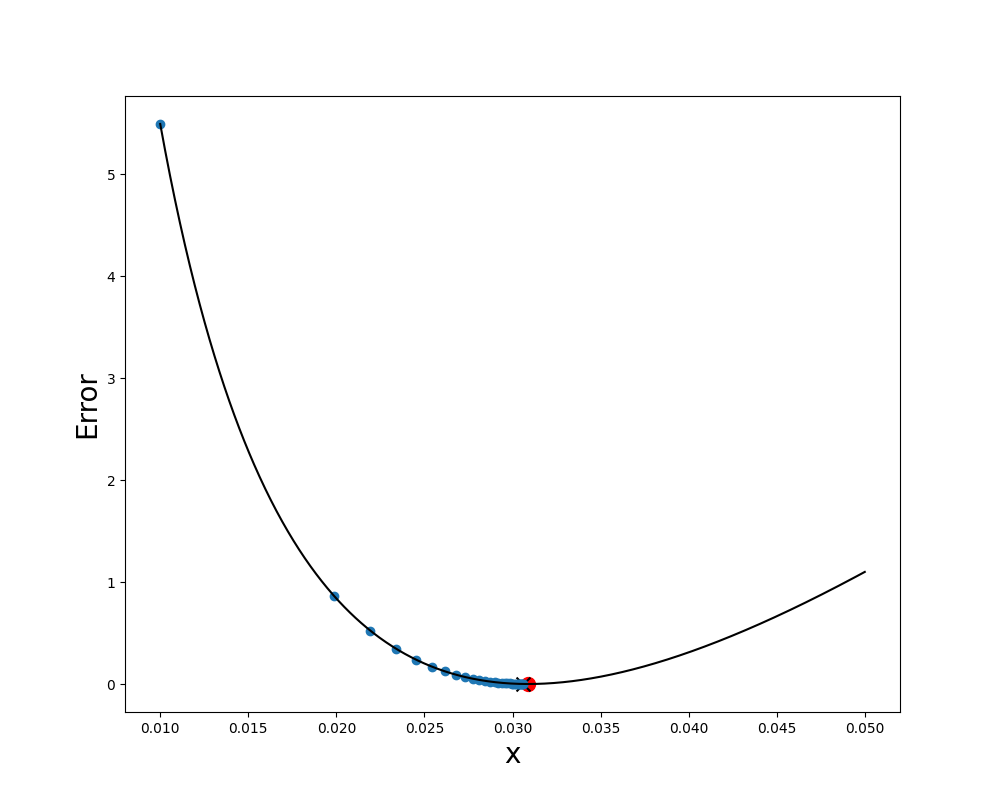

In [86]:
x_grid = np.linspace(0.01,0.05,1000)
error_grid = error_function(x_grid,ln_k)
x_opt = x_grid[np.argmin(error_grid)]


plt.figure(figsize=(10,8))
plt.clf()
plt.plot(x_grid, error_grid, c='k')
plt.scatter(x_opt, error_function(x_opt,ln_k), c='r', marker='o', s=100)
plt.scatter(x0, error_function(x0,ln_k), c='k', marker='x', s=100)
plt.scatter(x0_trj, error_function(x0_trj,ln_k))

# plt.xscale('log')
plt.xlabel('x',fontsize=20)
plt.ylabel('Error', fontsize=20)

## 3D gradient descent


In [89]:
def f_residuals(x,m0,k):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    ka1 = k[0]
    ka2 = k[1]
    kw = k[2]
    
    g1 = ka1*(m0 + xa1) - (xa1 - xa2)*(xa1 + xa2 + xw)
    g2 = ka2*(xa1 - xa2) - (xa2)*(xa1 + xa2 + xw)
    gw = kw -xw*(xa1 + xa2 + xw)
    return np.array([g1,g2,gw])

def jacobian_f_r(x,m0,k):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    ka1 = k[0]
    ka2 = k[1]
    kw = k[2]
    
    dg1_dxa1 = -ka1 - 2*xa1 - xw
    dg1_dxa2 = 2*xa2 + xw
    dg1_dxw = -xa1 + xa2
    
    dg2_dxa1 = ka2 - xa2
    dg2_dxa2 = -ka2 + 2*xa2 - xa1 - xw
    dg2_dxw = -xa2
    
    dg3_dxa1 = -xw
    dg3_dxa2 = -xw
    dg3_dxw = -xa1 - xa2 - 2*xw
    
    return np.array([[dg1_dxa1, dg1_dxa2, dg1_dxw], 
                     [dg2_dxa1, dg2_dxa2, dg2_dxw], 
                     [dg3_dxa1, dg3_dxa2, dg3_dxw]])

def error_function(x0, m0, k):
    g = f_residuals(x0,m0,k)
    return 0.5 * np.dot(g,g)

def gradient_error_function(x0, m0, k):
    g = f_residuals(x0, m0, k)
    jac_g = jacobian_f_r(x0, m0, k)
    return jac_g.T @ g

In [114]:
k = np.array([5.6E-2,1.5E-4,1E-14])
m0 = 1E-4
x0 = np.array([9.8E-5,4.99E-5,6.67E-11])
# x0 = np.random.normal(-10,10,size=(3,))*1E-3

print(f_residuals(x0, m0, k))
print(error_function(x0, m0, k))

[ 1.10808860e-05 -1.65213328e-10  1.35065551e-16]
6.13930173614041e-11


In [117]:
eta = 1E2
x0_trj = np.array(x0)
error_trj = np.array(error_function(x0, m0, k))
for i in range(100):
    dx0 = gradient_error_function(x0, m0,k)
    e = error_function(x0, m0,k)
    print(f'Iteration {i+1}, e = ', e , 'x = ',x0)
    x0 = x0 - eta * dx0
    x0_trj = np.append(x0_trj, x0)
    error_trj = np.append(error_trj, e)

Iteration 1, e =  4.616616397857521e-25 x =  [5.61002182e-02 1.49204236e-04 1.65238761e-11]
Iteration 2, e =  2.802182577566816e-25 x =  [5.61002182e-02 1.49204236e-04 1.29128196e-11]
Iteration 3, e =  1.7008615918762533e-25 x =  [5.61002182e-02 1.49204236e-04 1.00994930e-11]
Iteration 4, e =  1.0323845657334373e-25 x =  [5.61002182e-02 1.49204236e-04 7.90766268e-12]
Iteration 5, e =  6.266340750758536e-26 x =  [5.61002182e-02 1.49204236e-04 6.20003557e-12]
Iteration 6, e =  3.8035279263623435e-26 x =  [5.61002182e-02 1.49204236e-04 4.86964408e-12]
Iteration 7, e =  2.3086533742638557e-26 x =  [5.61002182e-02 1.49204236e-04 3.83315340e-12]
Iteration 8, e =  1.4013007591362123e-26 x =  [5.61002182e-02 1.49204236e-04 3.02563373e-12]
Iteration 9, e =  8.505586973220781e-27 x =  [5.61002182e-02 1.49204236e-04 2.39650843e-12]
Iteration 10, e =  5.1626946883999916e-27 x =  [5.61002182e-02 1.49204236e-04 1.90636440e-12]
Iteration 11, e =  3.1336400608888256e-27 x =  [5.61002182e-02 1.49204236

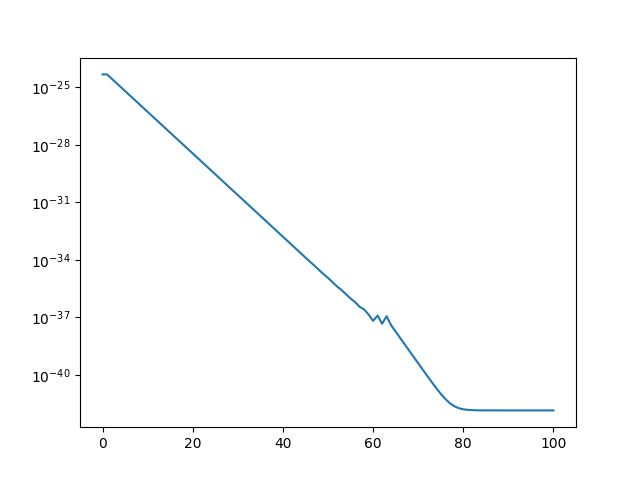

In [120]:
plt.figure(0)
plt.clf()
plt.plot(np.arange(error_trj.shape[0]),error_trj)
plt.yscale('log')
plt.show()